In [2]:
import os, sys, glob
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import lightkurve as lk
path = os.path.dirname(os.getcwd())

sys.path.append(path)
from kepler_apertures import KeplerFFI, KeplerPSF, EXBAsources

sys.path.append('%s/Work/BAERI/ADAP/psfmachine/' % os.environ['HOME'])
from psfmachine import Machine

In [3]:
ch = 9
qu = 5
psf = KeplerFFI(quarter=qu, channel=ch, plot=False, save=True)

Will query with this (ra, dec, radius, epoch):  [286.62339221] [39.77206637] [1.1120632957506742] 2010.3025743100884
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
Saving query to file...
../data/catalogs/ffi/5/channel_9_gaia_xmatch.csv
Cleaning sources table...
Saturated pixels 2407
Bright pixels 46741
Total Gaia sources 10907


In [4]:
# turn off plots and save inside the functions
psf.plot = False
psf.save = False

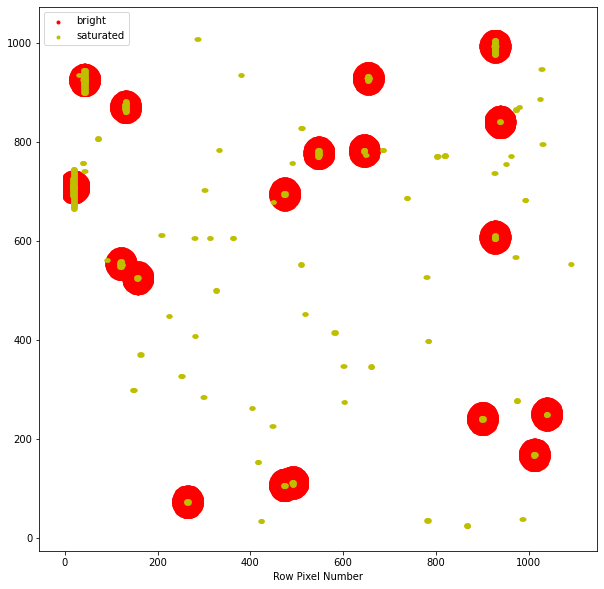

In [5]:
# plot rejected pixels due to saturation or bright-star halos
ax = psf.plot_pixel_masks()

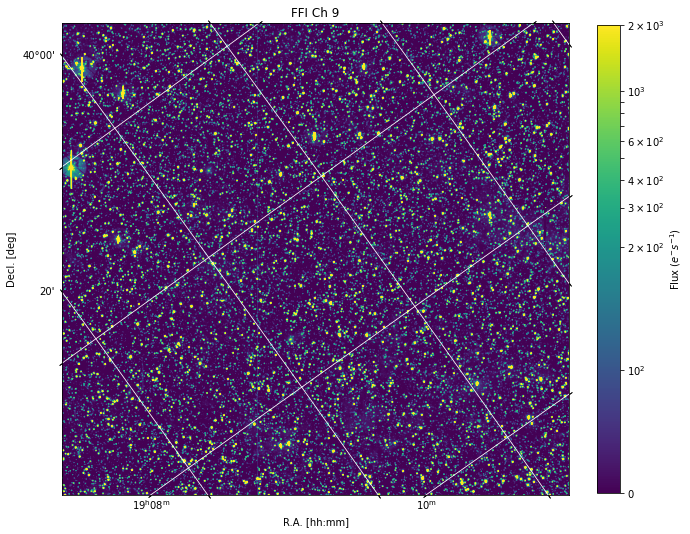

In [6]:
# plot FFI ch image
_ = psf.plot_image(sources=False)

In [86]:
# create sparse arrays for later use
psf._create_sparse()

Gaia sources: 100%|██████████| 9458/9458 [01:20<00:00, 116.81it/s]


to polar coordinates...


In [87]:
psf.show = True
psf.plot = True
psf.save = True
# find PSF edges as fn of flux to then limit the radius of the PSF fitting
radius = psf._find_psf_edge(psf.r, psf.dflux, psf.gf, 
                            radius_limit=6.0, 
                            cut=200, dm_type="cubic")

In [88]:
psf.show = True
psf.plot = True
psf.save = True
# fit PSF model in polar coordinates to the filtered/clean data
psf_model = psf._build_psf_model(psf.r, psf.phi, psf.dflux, 
                         psf.gf, radius * 2., 
                         psf.dx, psf.dy,
                         rknots=5,
                         phiknots=15)

# Contaminated pixels:  11782


# Load EXBA masks data

In [111]:
exba = EXBAsources(quarter=qu, channel=ch)

TargetPixelFileCollection of 4 objects:
	100002059 (1 KeplerTargetPixelFiles) Quarters: 5
	100002060 (1 KeplerTargetPixelFiles) Quarters: 5
	100002061 (1 KeplerTargetPixelFiles) Quarters: 5
	100002062 (1 KeplerTargetPixelFiles) Quarters: 5

Loading query from file...
../data/catalogs/exba/5/channel_53_gaiadr2_xmatch.csv


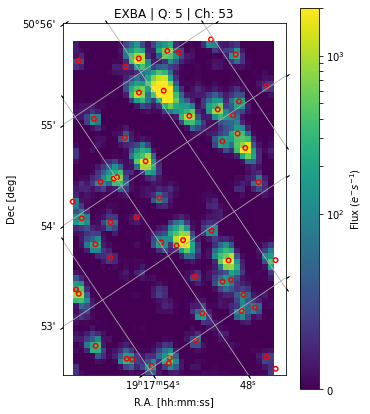

In [112]:
exba.plot_image();

## Create a PSF object

In [113]:
kpsf = KeplerPSF(quarter=qu, channel=ch)

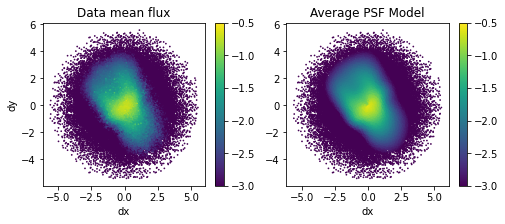

In [126]:
kpsf.plot_mean_PSF();

In [114]:
psf_exba = kpsf.evaluate_PSF(exba.flux, exba.dx, exba.dy, exba.gaia_flux[:, 0])
psf_exba

[1.49231798 1.95064478 1.19759767 2.44982475 1.40978202 1.95162508
 1.59208087 1.37227219 1.49888338 1.17091407 1.40629788 1.39284806
 1.07662484 1.30321006 1.34308607 1.12765801 1.39481249 1.018406
 1.88463209 1.13209344 1.68258652 1.02638635 2.24286192 1.2620702
 1.29966621 1.08675557 1.13042619 1.19420741 1.66709299 1.40754475
 1.44673954 1.23766841 1.98883496 1.41807276 1.30218174 1.86120105
 2.24119202 1.33330735 1.47113259 2.28312608 1.08601837 1.68041931
 1.23676953 1.16655739 1.24415256 1.47279512 1.25517866 3.09892439
 1.04041946 1.90643567 1.50722028 1.98505138 2.16041732 1.48089983
 1.34688294]


<55x2160 sparse matrix of type '<class 'numpy.float64'>'
	with 404 stored elements in Compressed Sparse Row format>

In [118]:
for s in range(exba.sources.shape[0]):
    ap_mask, crwd, cmplt, cut = kpsf.optimize_aperture(psf_exba, idx=s, target_complet=0.5, target_crowd=1.)
    exba.aperture_mask[s] = ap_mask
    exba.FLFRCSAP[s] = crwd
    exba.CROWDSAP[s] = cmplt
    exba.cut[s] = cut
exba.aperture_mask_2d = exba.aperture_mask.reshape(exba.N_sources, exba.N_row, exba.N_col)

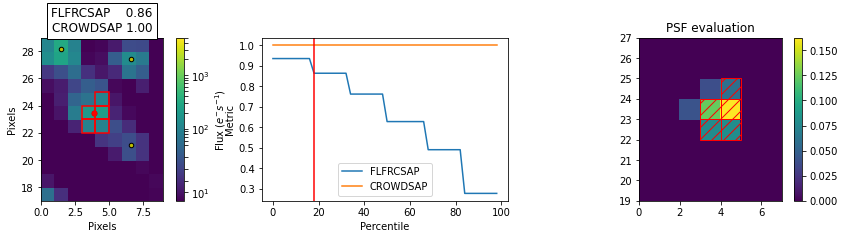

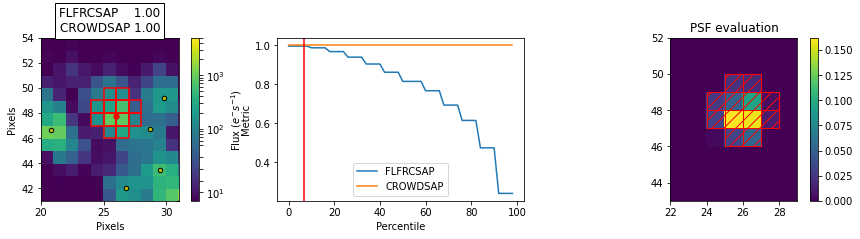

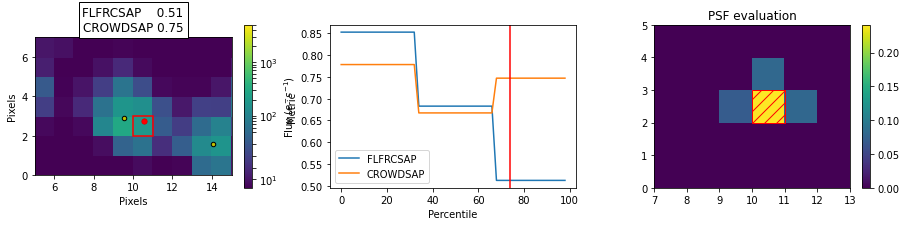

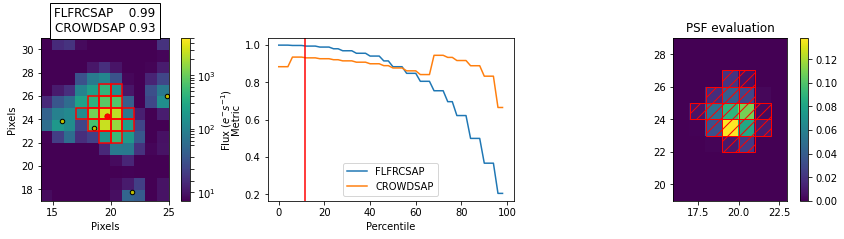

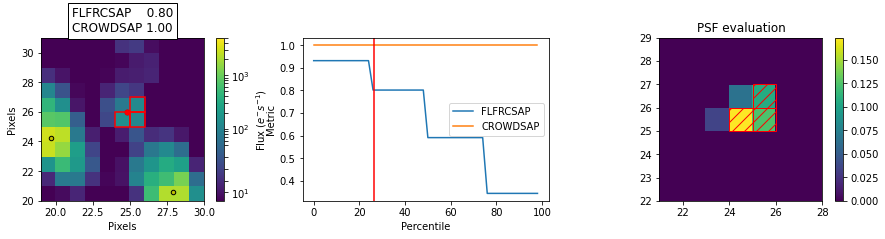

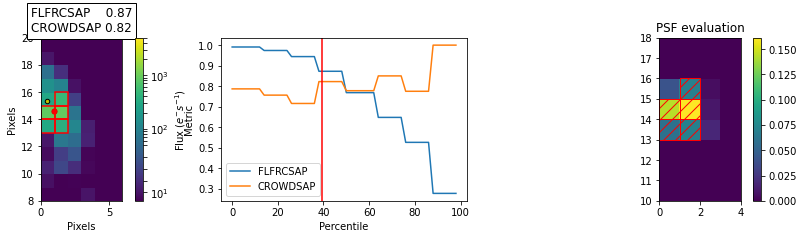

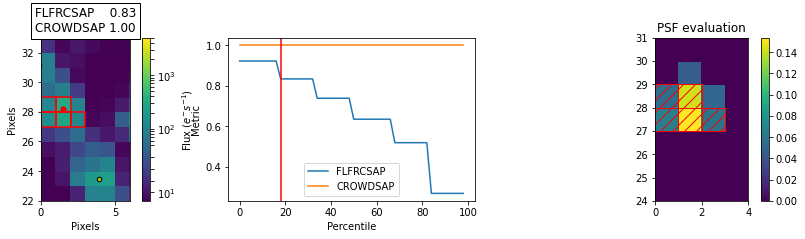

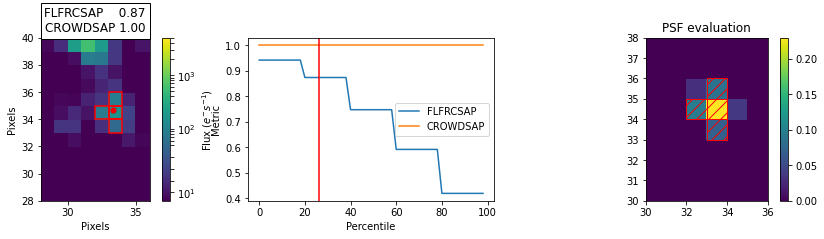

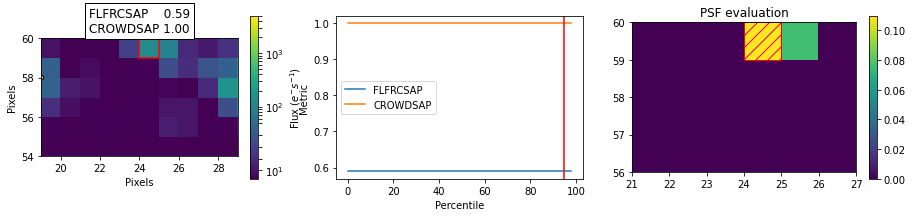

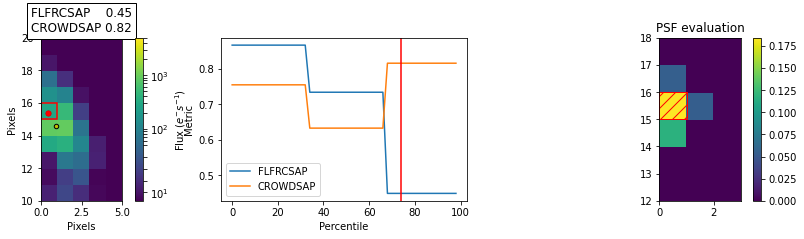

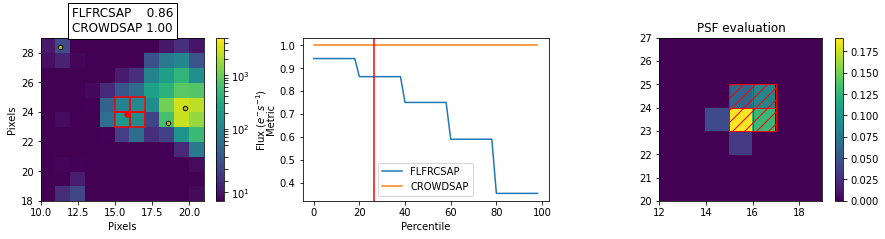

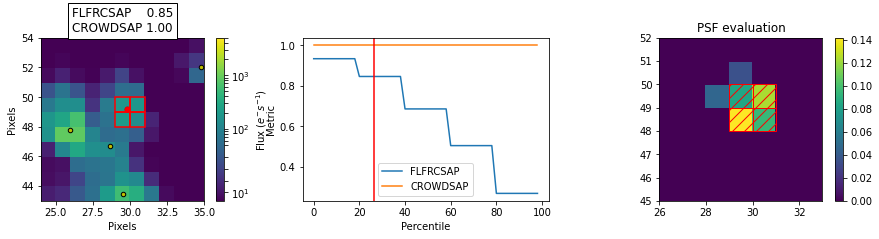

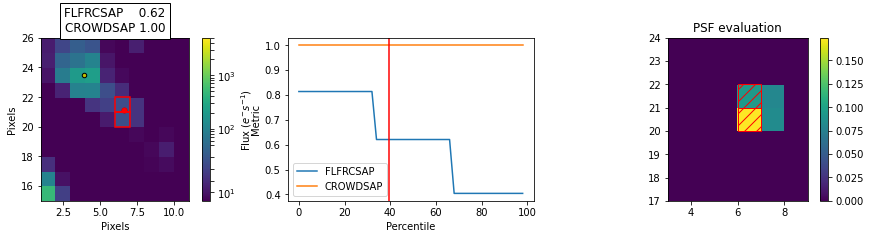

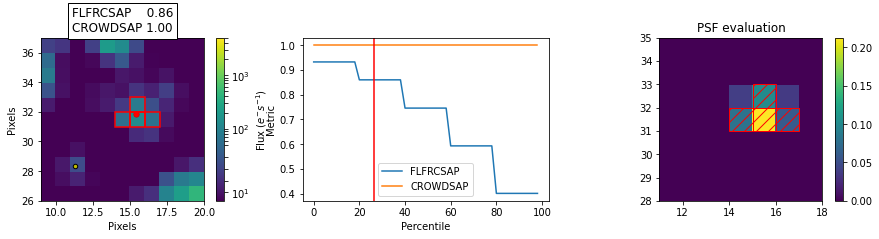

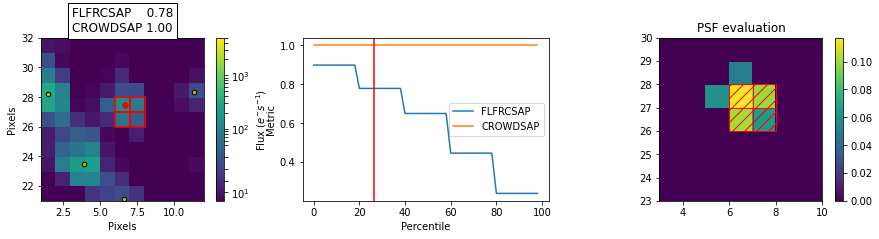

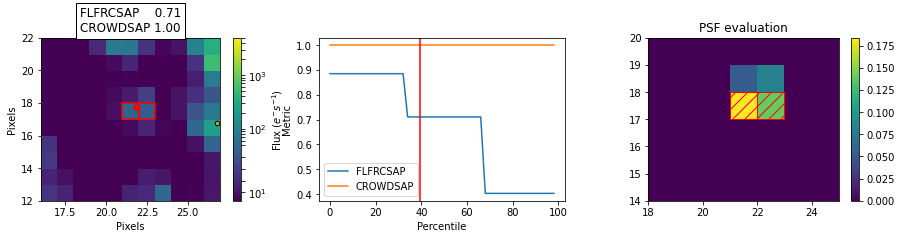

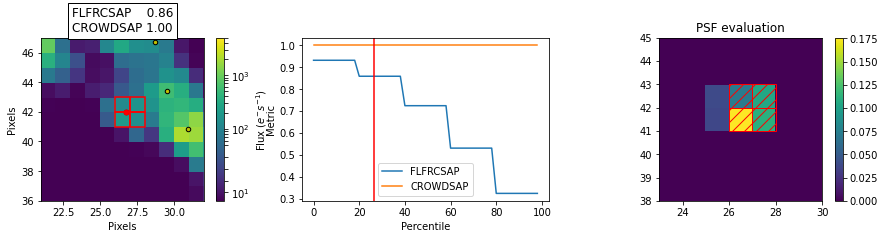

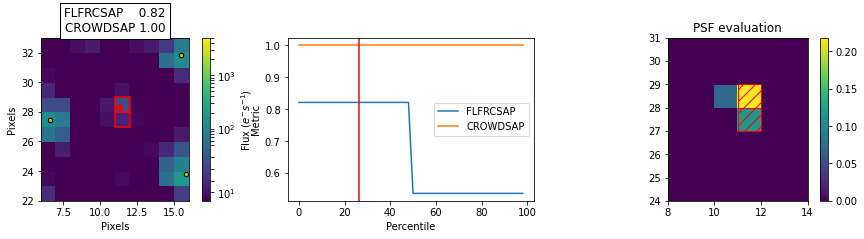

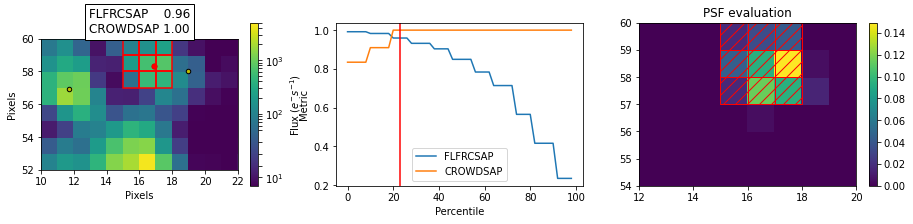

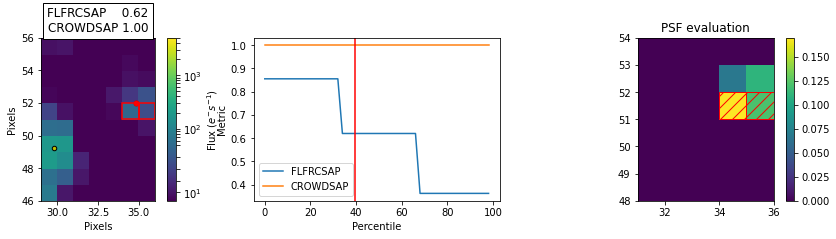

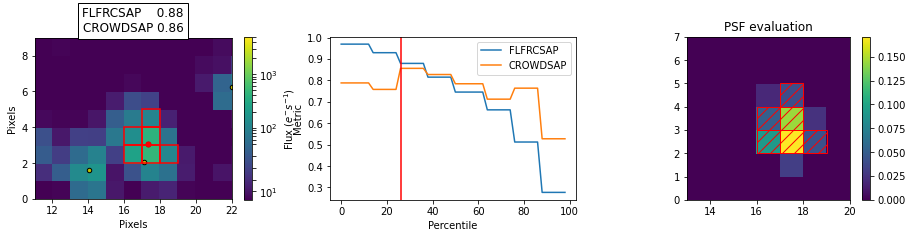

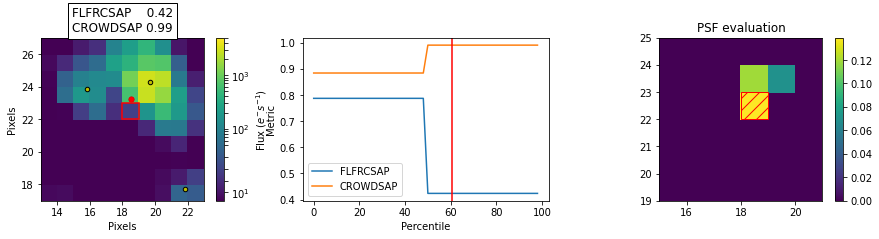

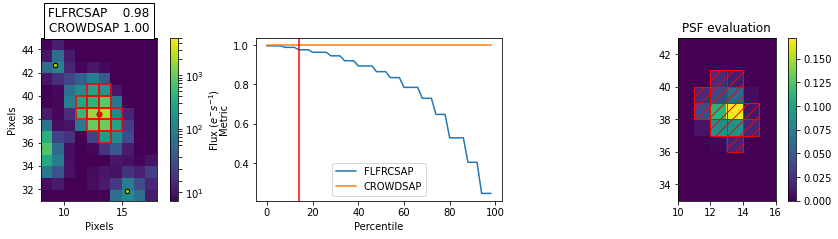

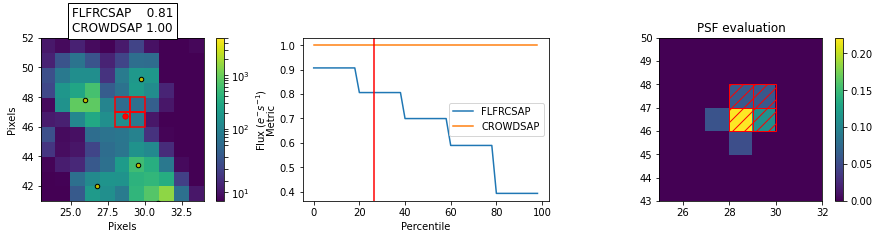

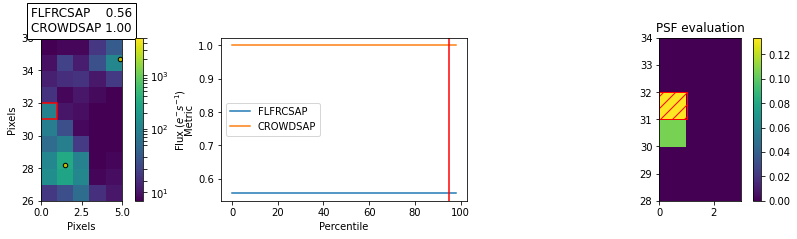

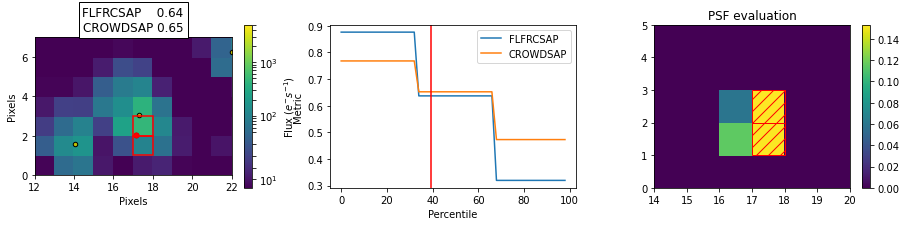

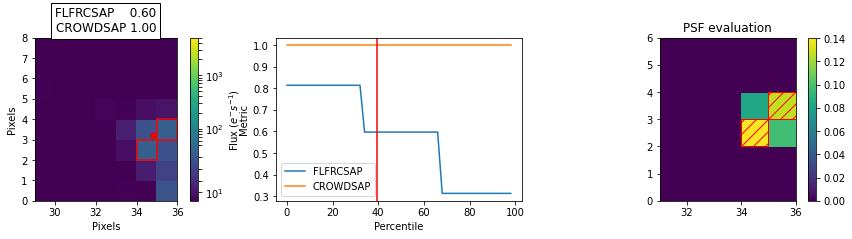

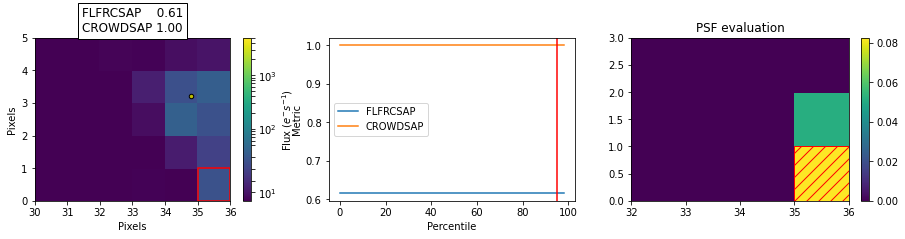

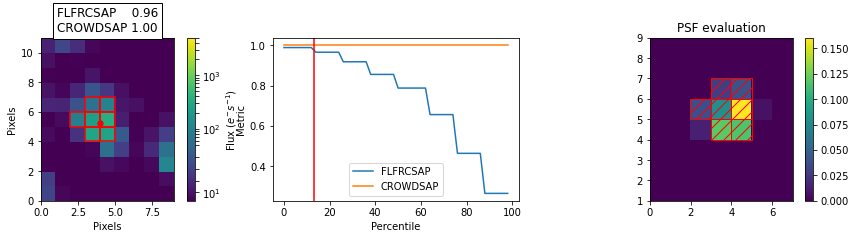

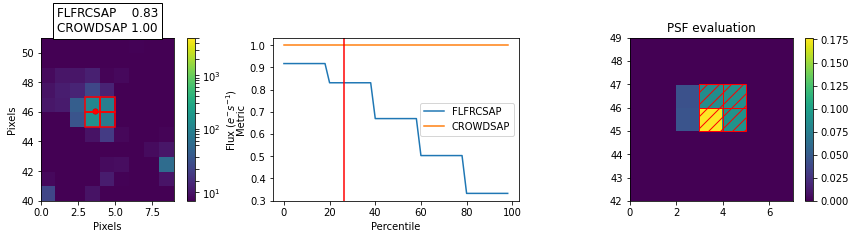

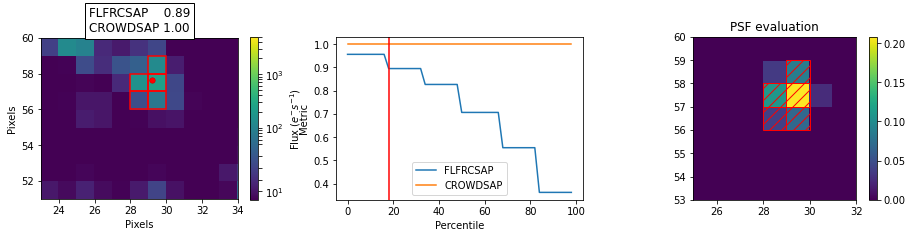

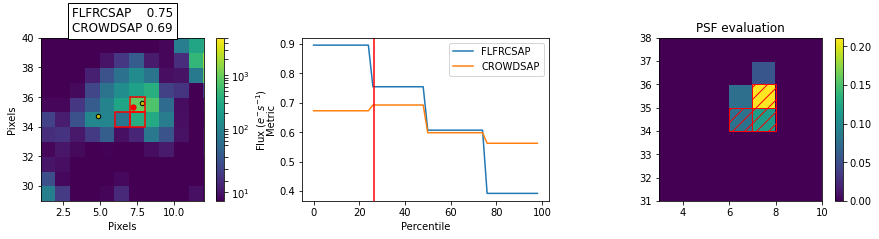

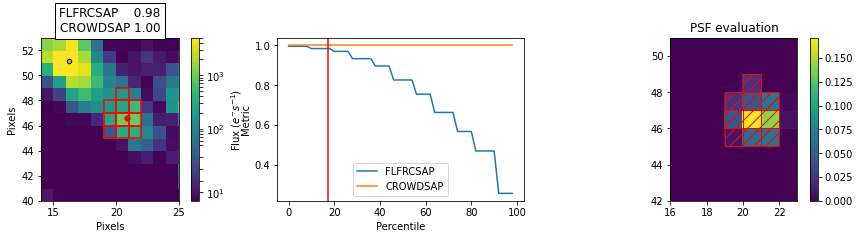

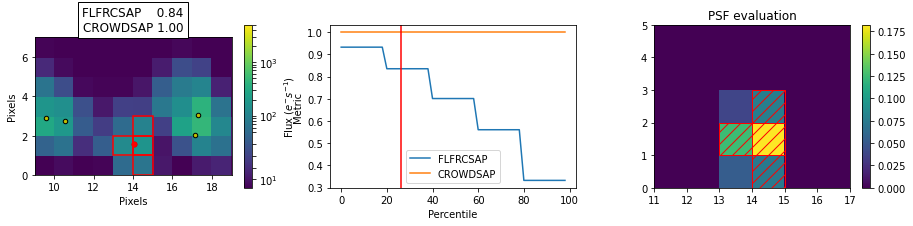

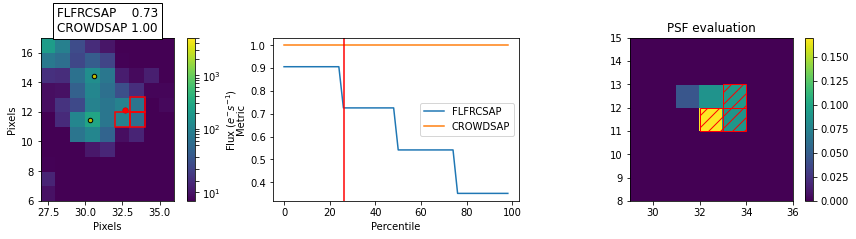

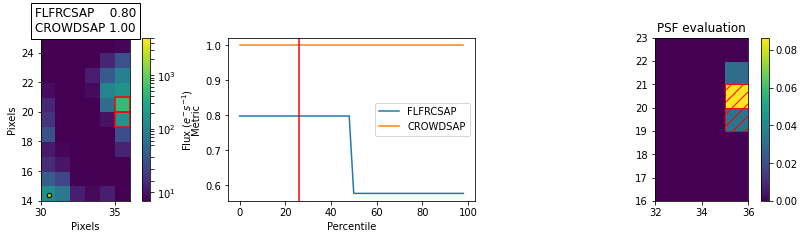

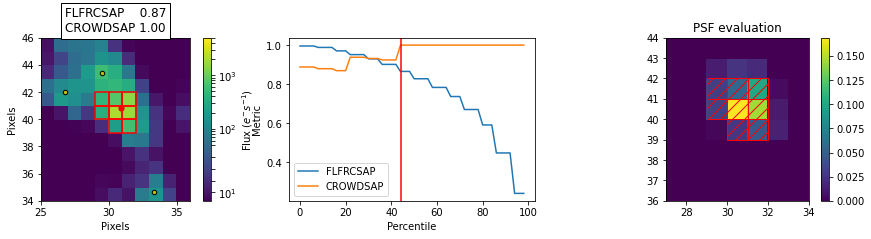

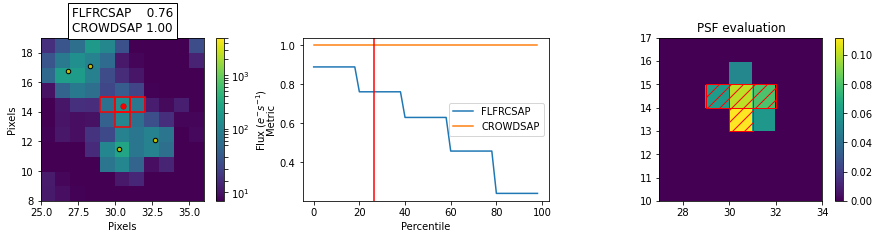

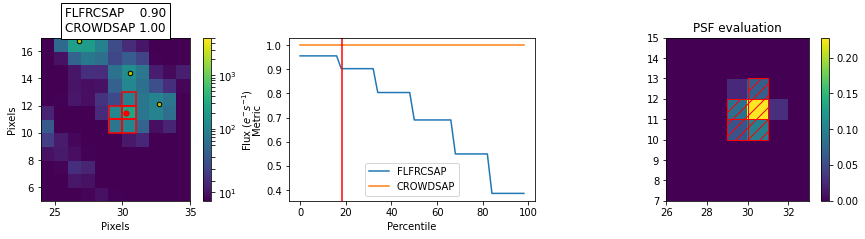

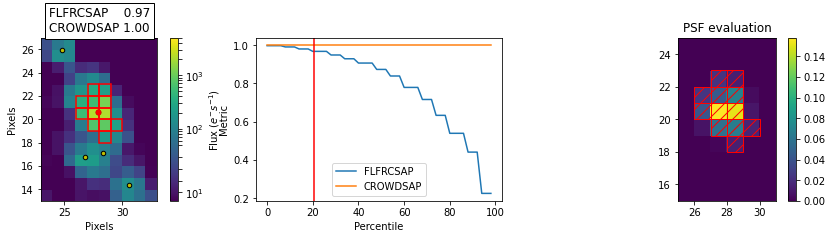

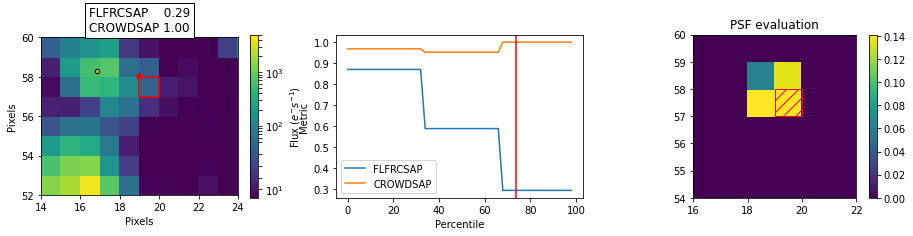

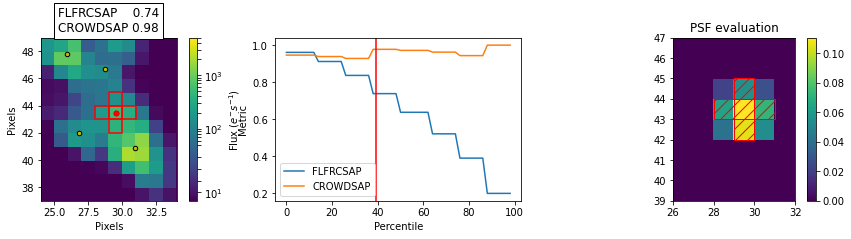

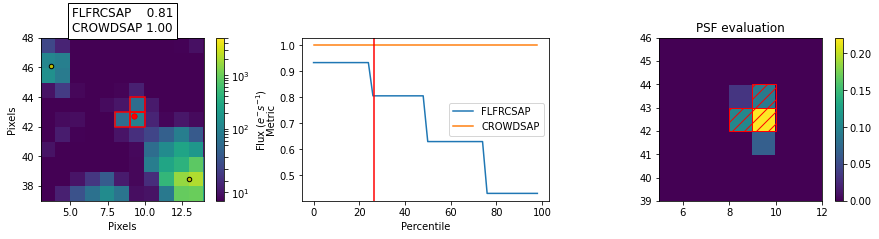

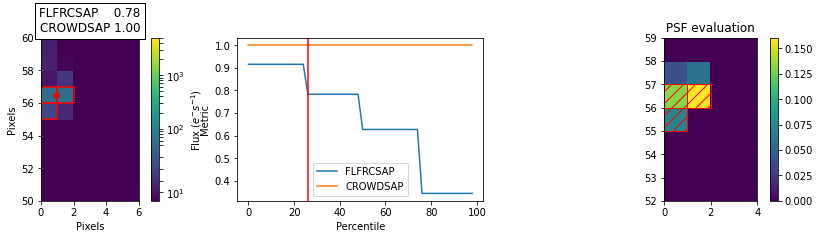

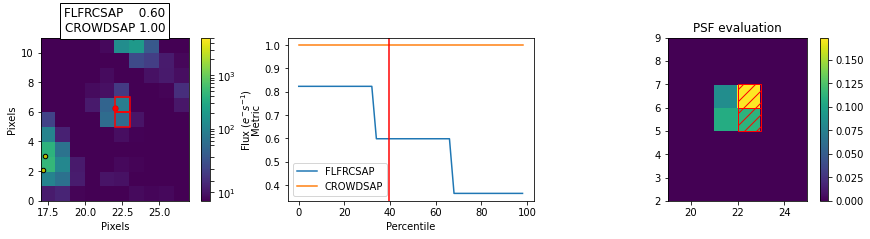

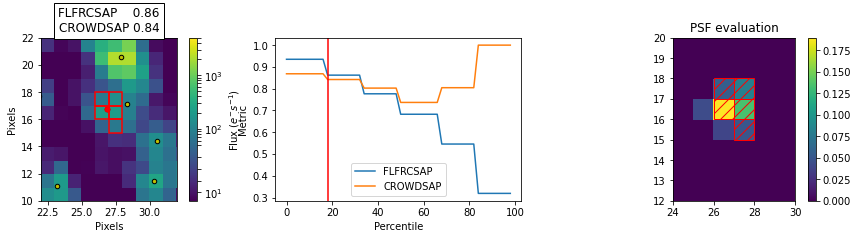

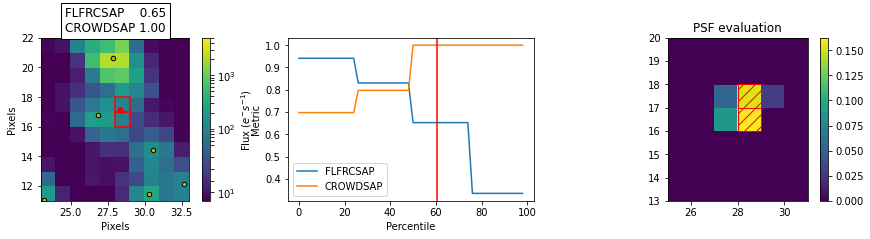

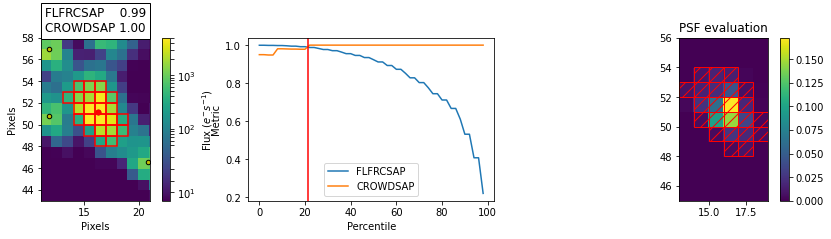

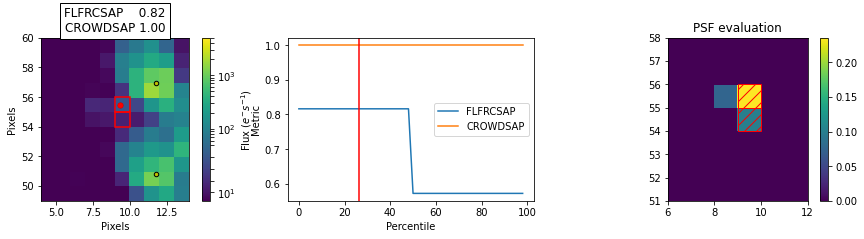

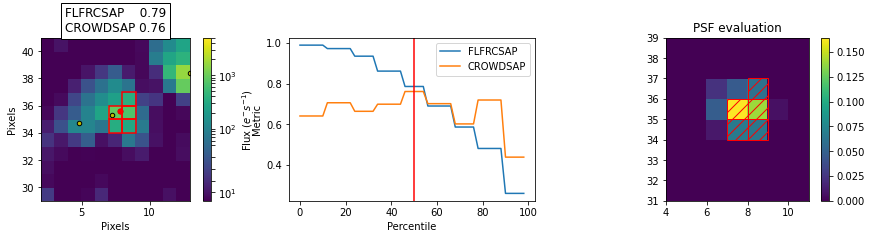

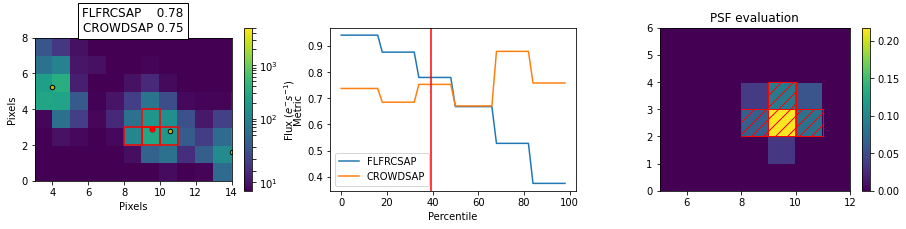

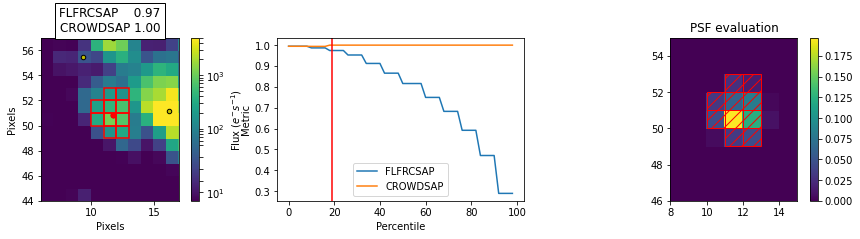

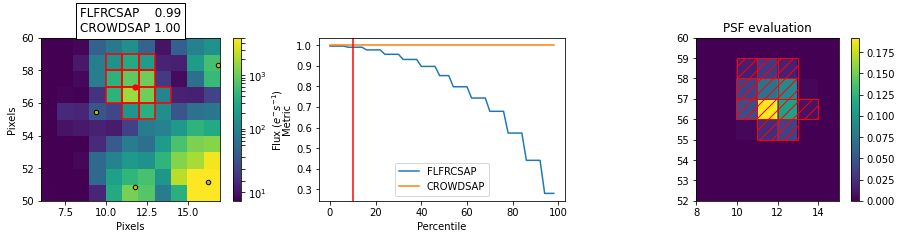

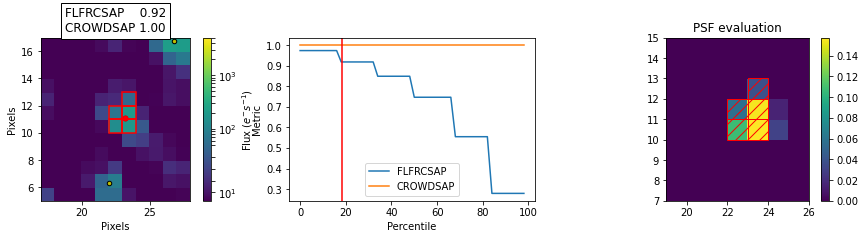

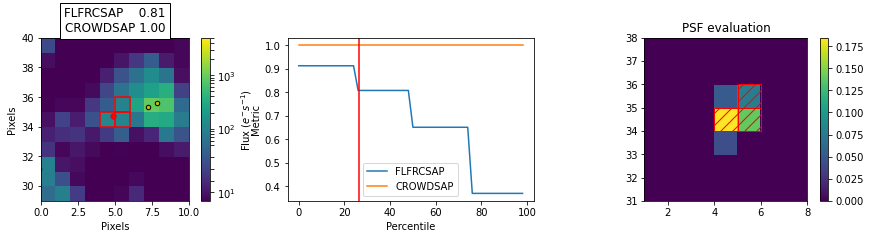

In [119]:
for s in range(exba.sources.shape[0]):
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    ax[0] = exba.plot_stamp(source_idx=s, aperture_mask=True, ax=ax[0])
    ax[1] = kpsf.diagnose_metrics(psf_exba, idx=s, ax=ax[1])
    ax[1].axvline(exba.cut[s], ls='-', c='r')
    ax[2] = kpsf.plot_aperture(psf_exba[s].toarray().reshape(exba.flux_2d.shape[1:]), 
                               mask=exba.aperture_mask_2d[s], ax=ax[2], log=False)
    plt.show()
    # break

## Test on TPFs

In [120]:
tpfs_paths = np.sort(glob.glob("../../EXBA_pathfinder/data/near/*.fits"))[4:]
tpfs = lk.TargetPixelFileCollection([lk.KeplerTargetPixelFile(f) for f in tpfs_paths])

In [121]:
tpfs_c = Machine.from_TPFs(tpfs, magnitude_limit=18)
tpfs_c

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Machine (N sources, N times, N pixels): (377, 4492, 10555)

In [122]:
psf_tpfs = kpsf.evaluate_PSF(tpfs_c.flux, tpfs_c.dx, tpfs_c.dy, tpfs_c.source_flux_estimates[:, 0])
psf_tpfs

<377x10555 sparse matrix of type '<class 'numpy.float64'>'
	with 6847 stored elements in Compressed Sparse Row format>

In [123]:
tpfs_c.aperture_mask = np.zeros_like(tpfs_c.dx).astype(bool)
tpfs_c.FLFRCSAP = np.zeros(tpfs_c.sources.shape[0])
tpfs_c.CROWDSAP = np.zeros(tpfs_c.sources.shape[0])
tpfs_c.cut = np.zeros(tpfs_c.sources.shape[0])

for s in range(tpfs_c.sources.shape[0]):
    ap_mask, crwd, cmplt, cut = kpsf.optimize_aperture(psf_tpfs, idx=s, target_complet=0.5, target_crowd=1.)
    tpfs_c.aperture_mask[s] = ap_mask
    tpfs_c.FLFRCSAP[s] = crwd
    tpfs_c.CROWDSAP[s] = cmplt
    tpfs_c.cut[s] = cut

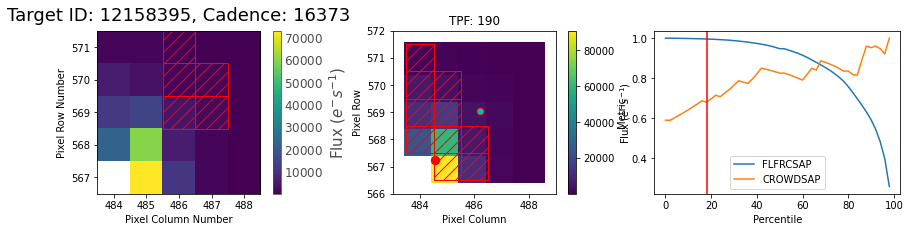

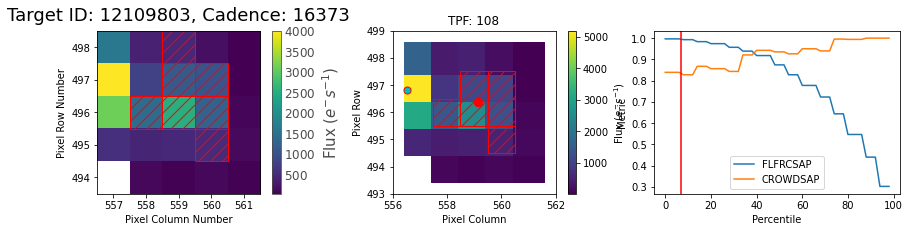

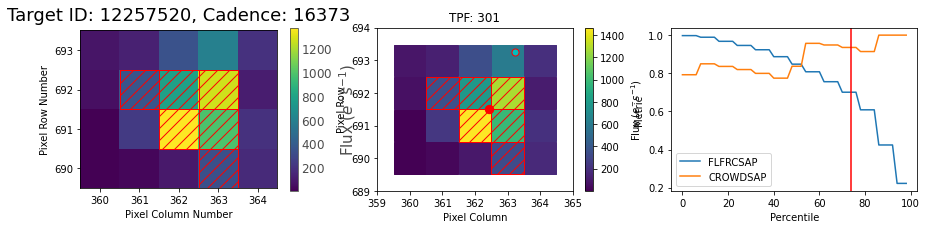

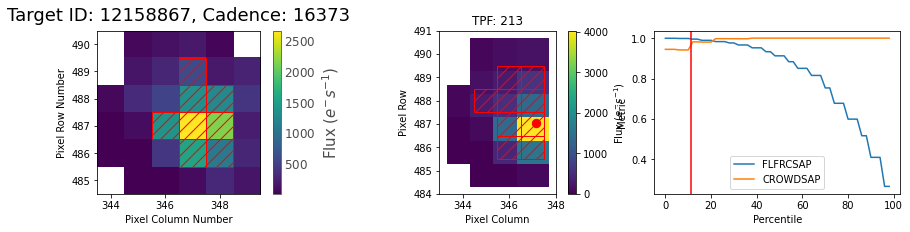

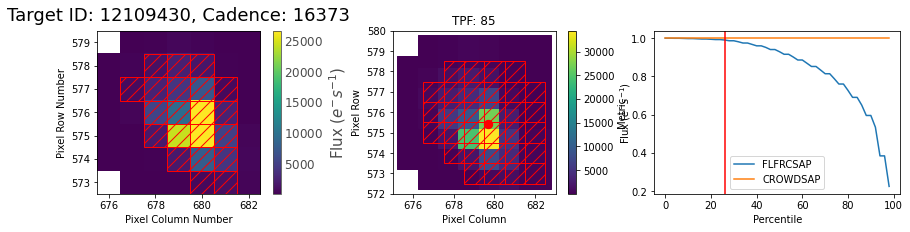

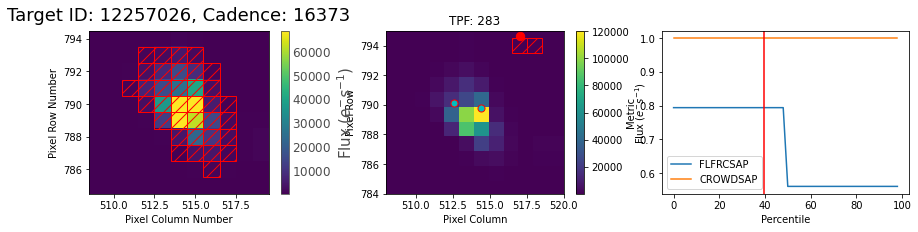

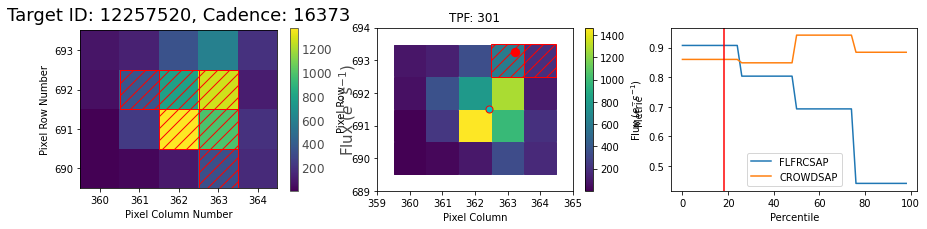

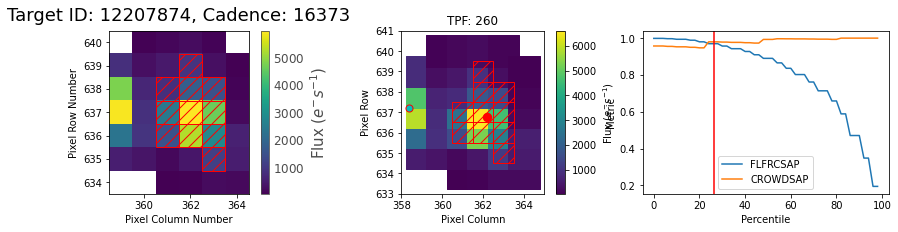

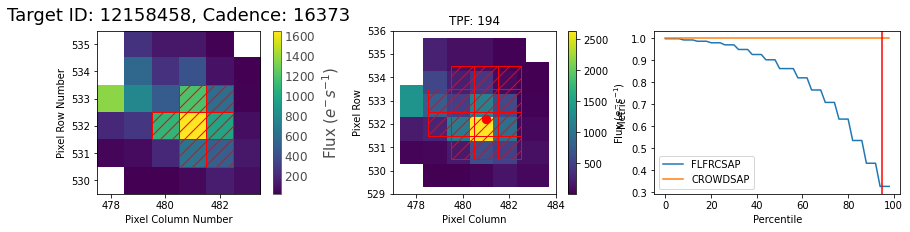

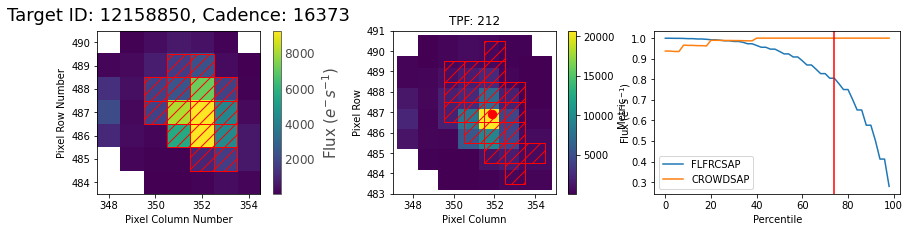

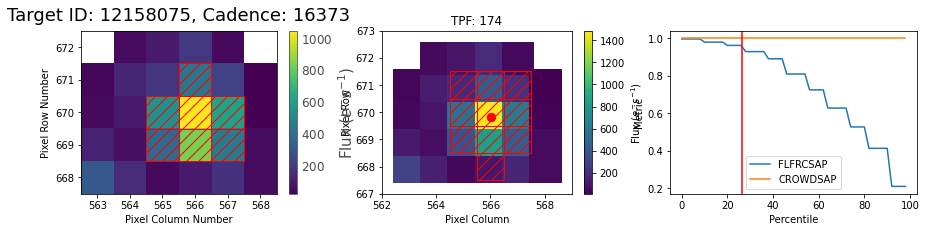

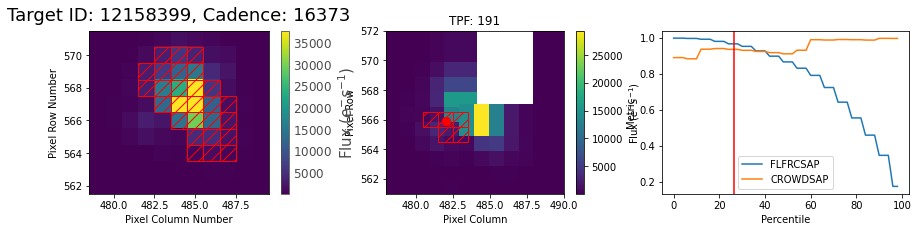

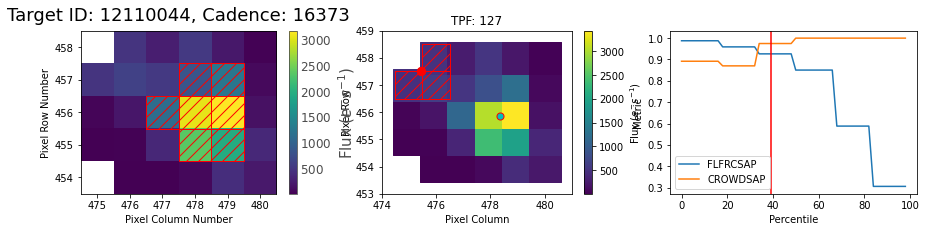

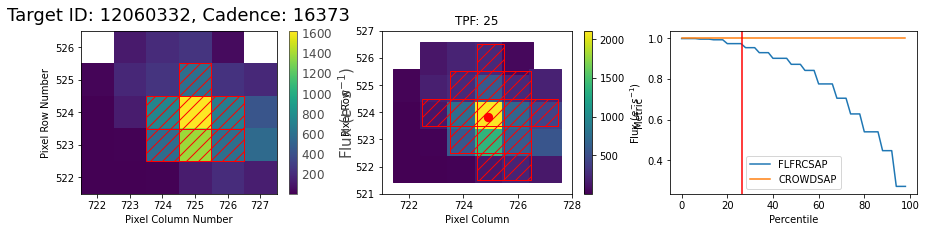

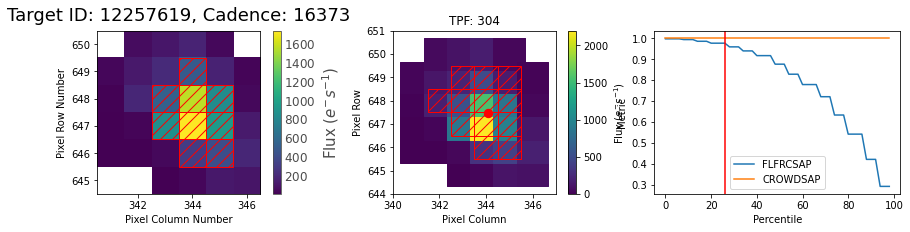

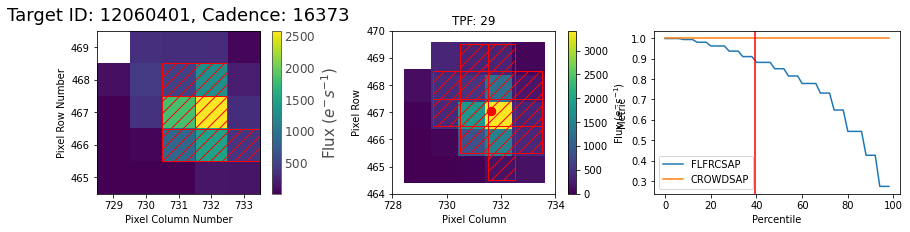

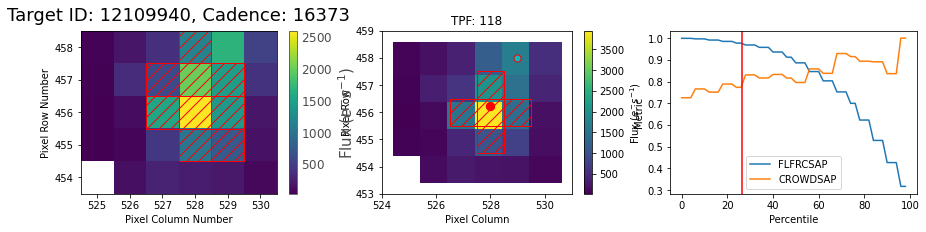

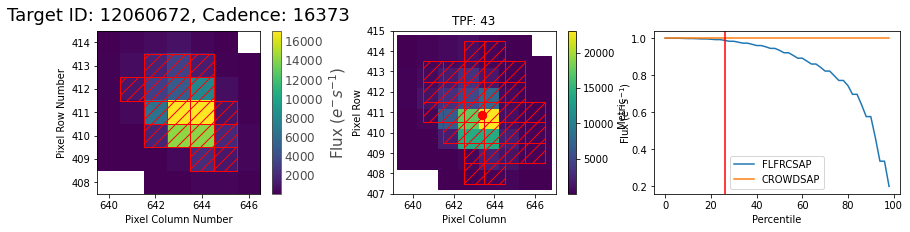

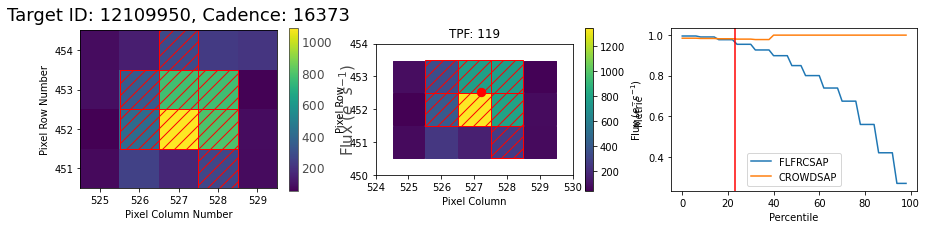

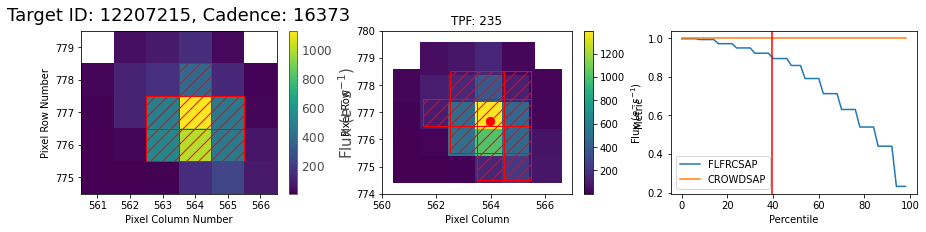

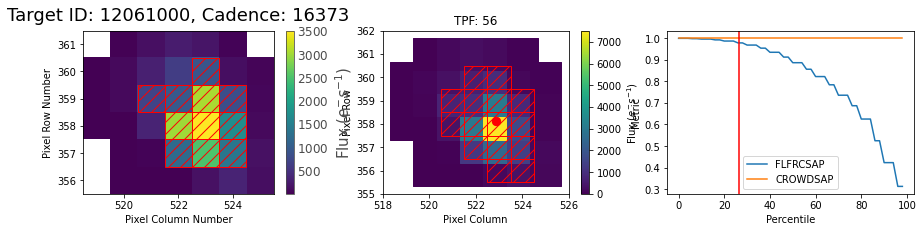

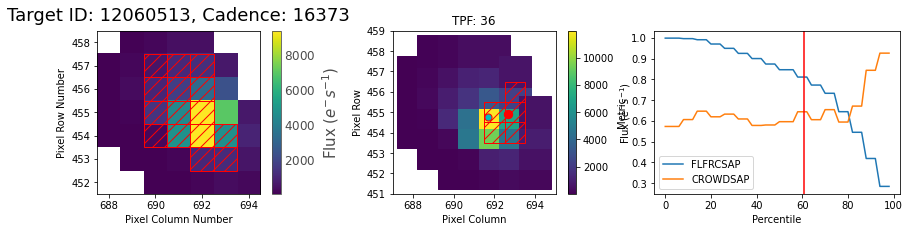

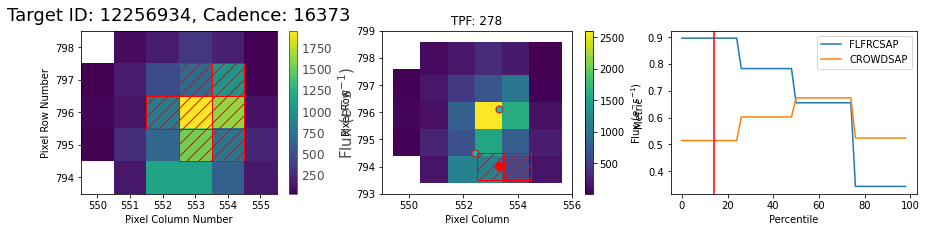

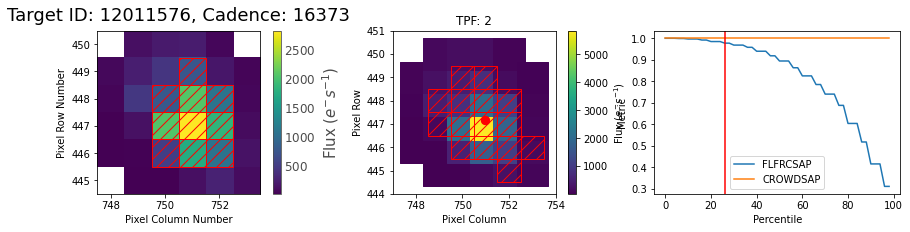

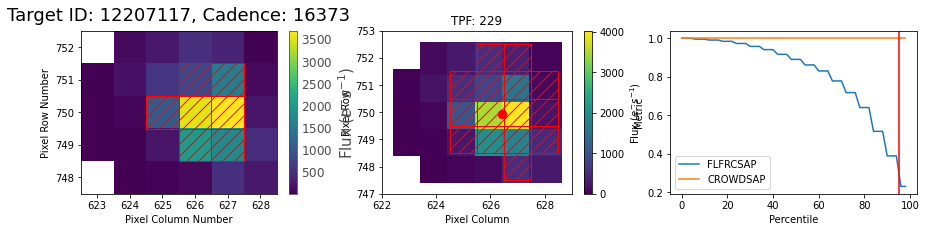

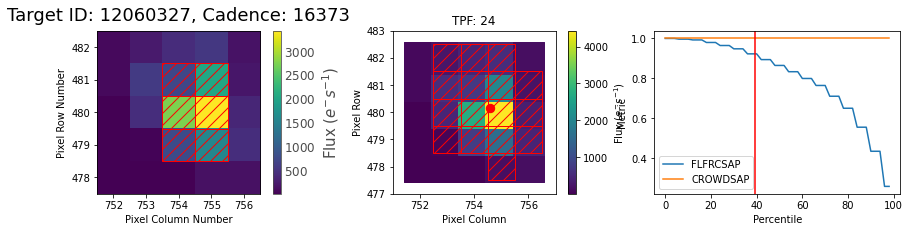

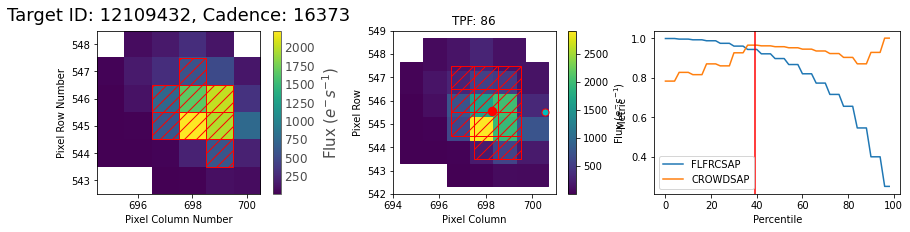

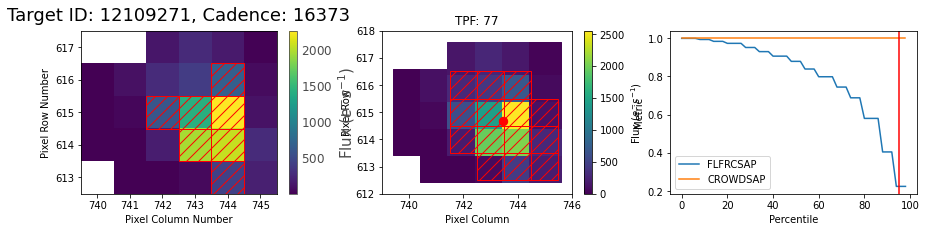

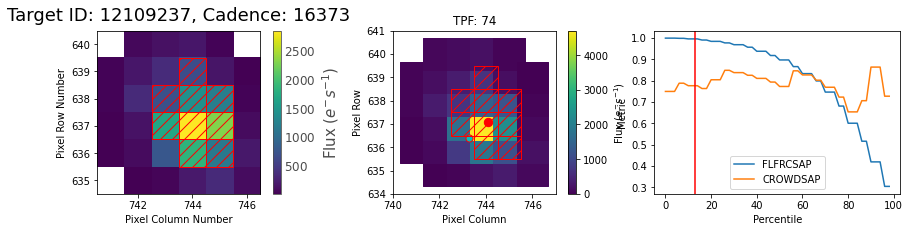

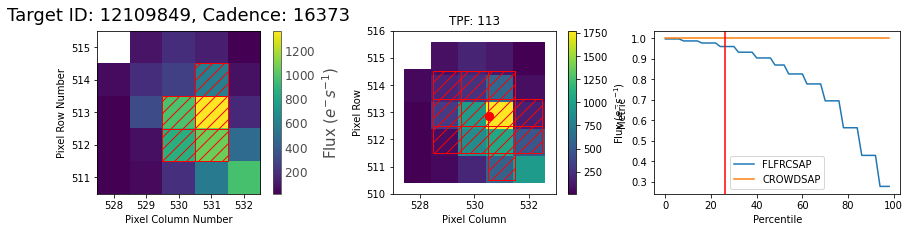

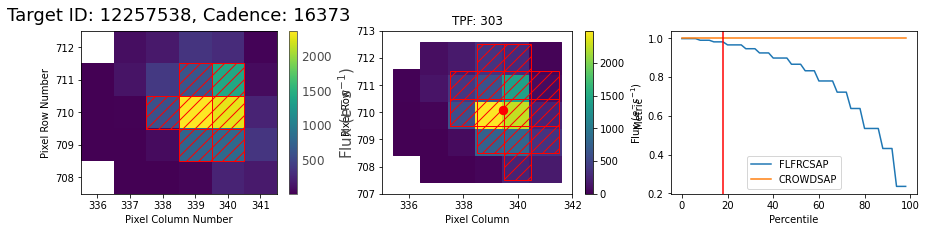

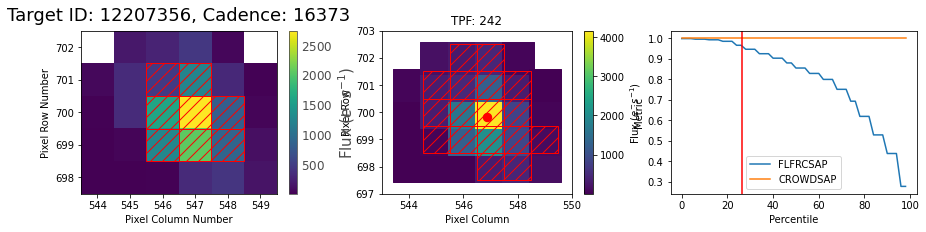

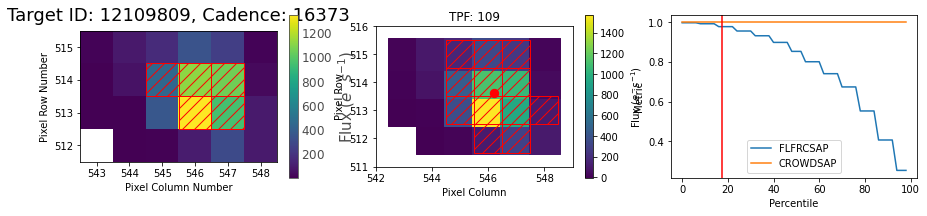

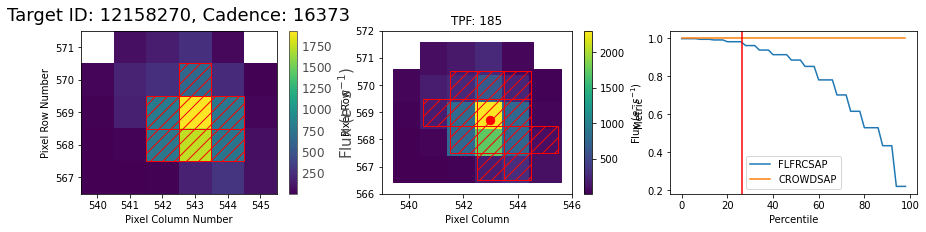

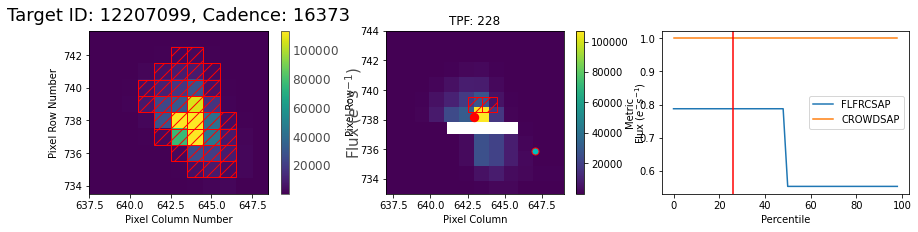

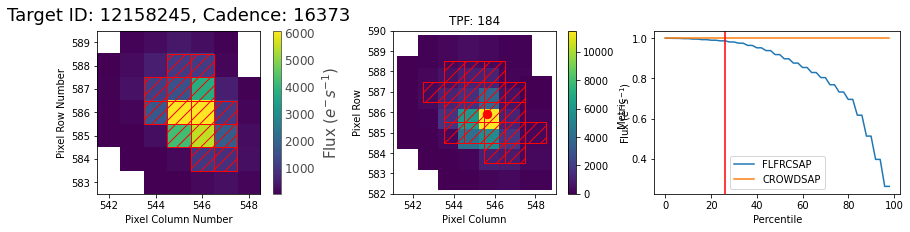

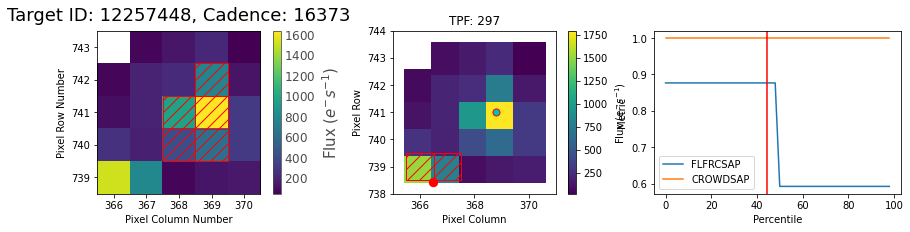

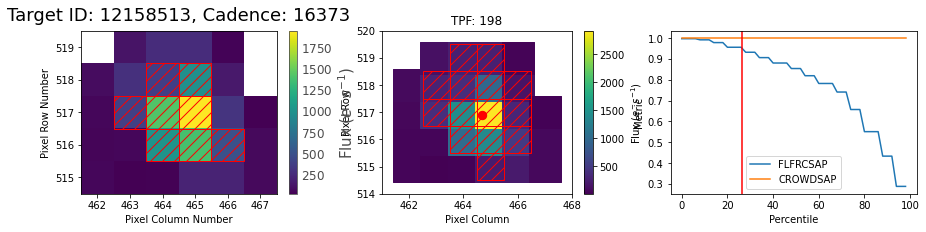

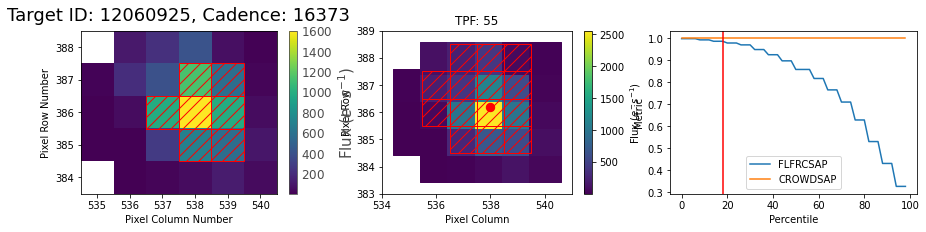

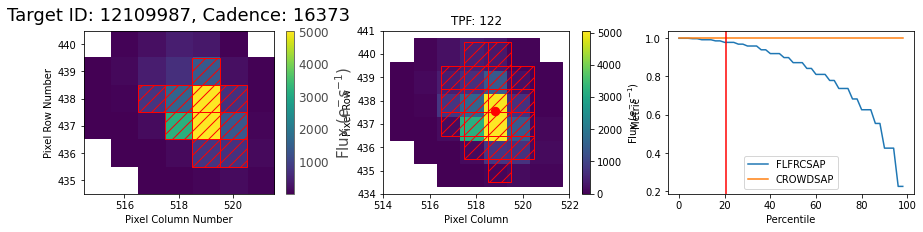

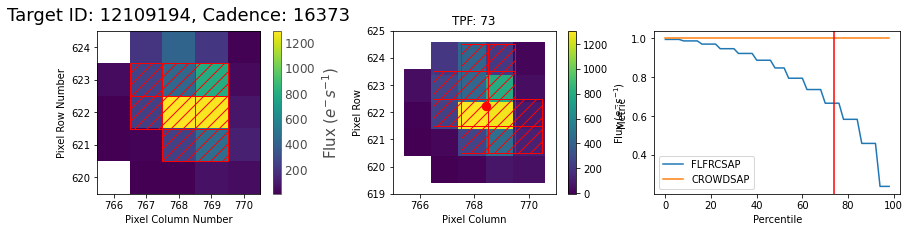

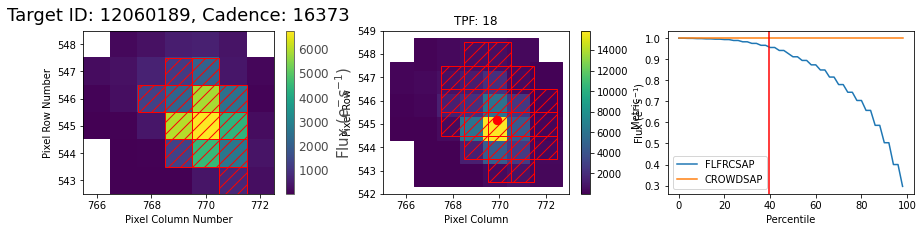

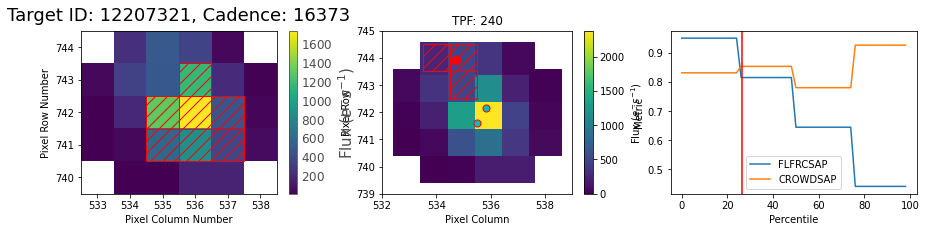

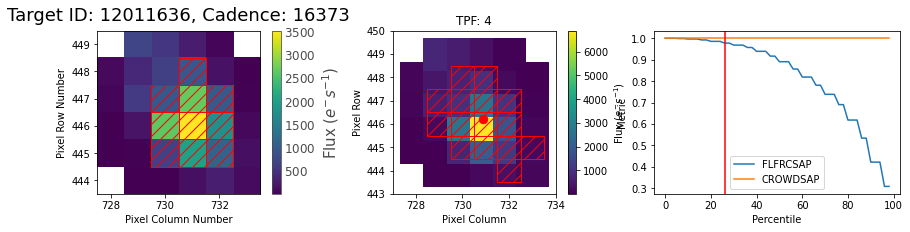

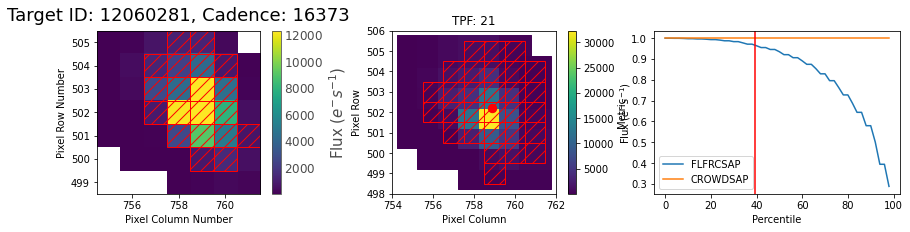

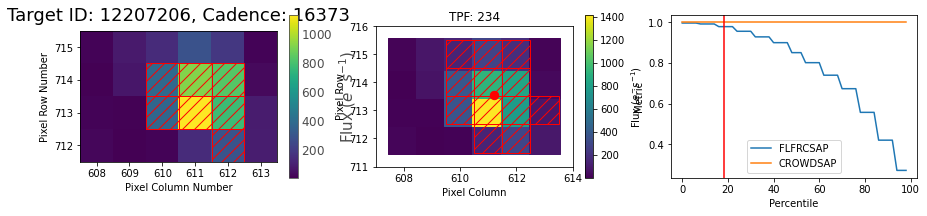

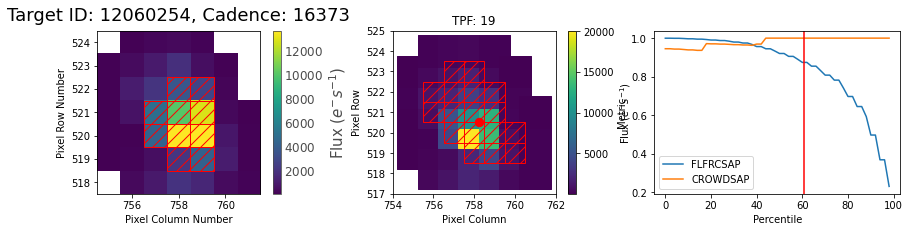

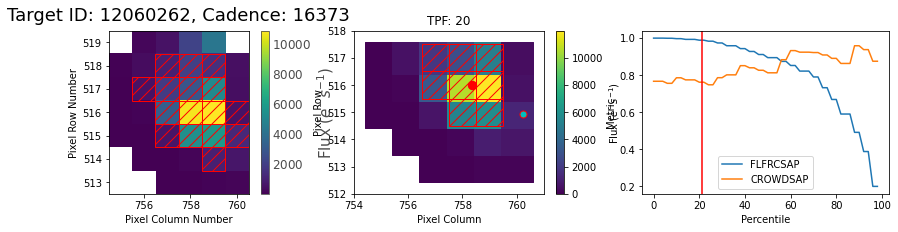

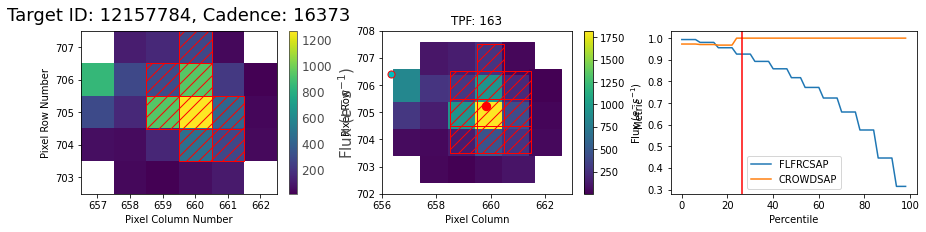

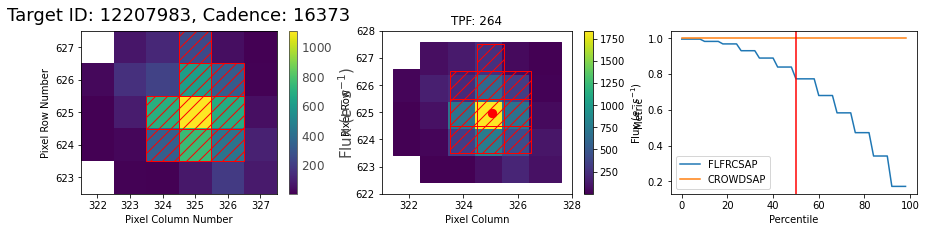

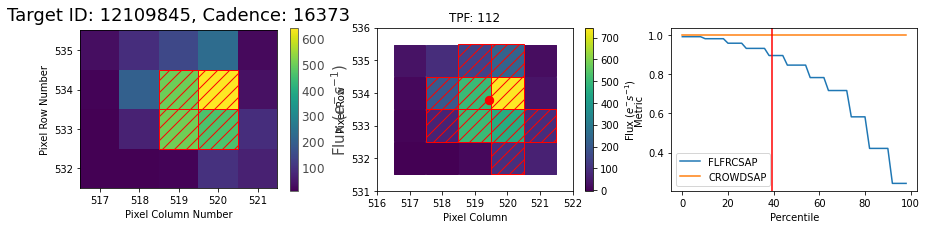

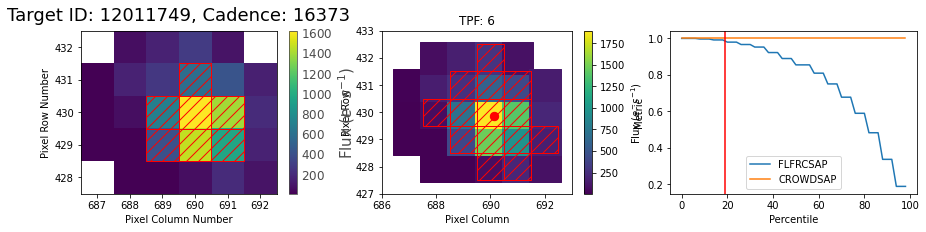

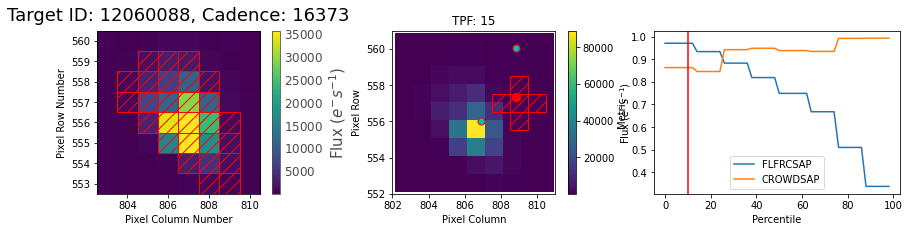

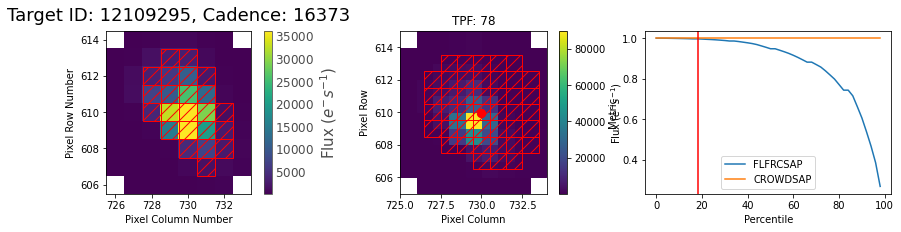

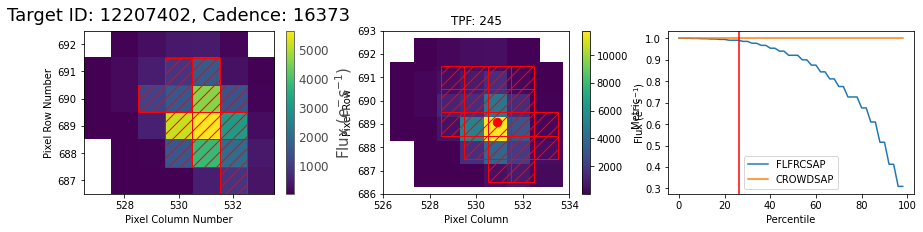

In [124]:
for s in range(exba.sources.shape[0]):
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    tpfs[tpfs_c.sources.loc[s, "tpf"]].plot(aperture_mask='pipeline', ax=ax[0]);
    ax[1] = tpfs_c.plot_source(s, ax=ax[1])
    ax[2] = kpsf.diagnose_metrics(psf_tpfs, idx=s, ax=ax[2])
    ax[2].axvline(exba.cut[s], ls='-', c='r')
    plt.show()
    # break